In [62]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd  
import importlib
import os
import numpy as np
from skimage import measure
from ipywidgets import interact
from ipywidgets import interact_manual
from IPython.display import display
from ipywidgets import widgets

In [63]:
import ipynb.fs.full.wspFFA as wspFirefly
import ipynb.fs.full.wspCS as wspCuckooSearch
import ipynb.fs.full.wspKH as wspKrillHerd
import ipynb.fs.full.wspEHO as wspElephantHerding
import ipynb.fs.full.wspABC as wspArtificialBeeColony

import ipynb.fs.full.plotGraph as plotGraph
import ipynb.fs.full.wspMultithreshold as wspMultithreshold
import ipynb.fs.full.dicomHandler as dicomHandler

importlib.reload(wspFirefly)
importlib.reload(wspCuckooSearch)
importlib.reload(wspKrillHerd)
importlib.reload(wspElephantHerding)
importlib.reload(wspArtificialBeeColony)

importlib.reload(plotGraph)
importlib.reload(wspMultithreshold)
importlib.reload(dicomHandler)

<module 'ipynb.fs.full.dicomHandler' (/mnt/6884ACCB84AC9CD6/OneDrive - FEI/Aulas/Graduacao/8 - Semestre/CC8421 - TRABALHO FINAL DE CURSO II/image-segmentation/dicomHandler.ipynb)>

In [64]:
folder_dir = "../Database/2EFVJVCN/"
file = "I1680000"
bio_algorithms = 'FFA'
dimension = 2
q = 1

In [65]:
image = folder_dir + file

In [66]:
dicom_image, pixel_array = dicomHandler.read_dicom_image(image)

transformed_pixel_array = dicomHandler.image_transformation(pixel_array)

original_image = pixel_array.copy()

print(pixel_array.min(), pixel_array.max())
    
hu_image = dicomHandler.transform_to_hu(dicom_image, transformed_pixel_array)

print(hu_image.min(), hu_image.max())

hist, bin_edges, best_thresholds, img_thres = wspMultithreshold.wspMultithreshold(hu_image, bio_algorithms, dimension, q)

0 2946
-1024.0 47222.32103980752


In [67]:
high_intensity = wspMultithreshold.get_high_intensity_pixels(img_thres)

print(high_intensity.min(), high_intensity.max())

pixel_array = dicomHandler.transform_to_pixel_array(dicom_image, high_intensity)

print(pixel_array.min(), pixel_array.max())

hard_tissue = wspMultithreshold.get_largests_regions(pixel_array, original_image)

print(hard_tissue.min(), hard_tissue.max())

-1024.0 47223.0
-1024.0 47223.0
-17289 0
-17289 0


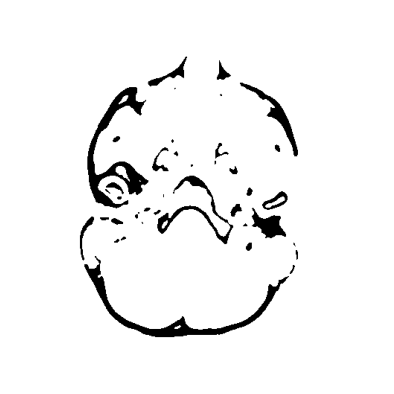

In [68]:
dicomHandler.show_dicom_image(pixel_array)

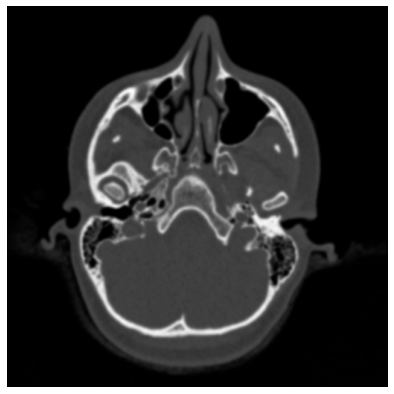

In [69]:
dicomHandler.show_dicom_image(hu_image)

In [70]:
min_val, max_val = original_image.min(), original_image.max()
print(min_val, max_val)

0 2946


In [71]:
org = original_image.copy()

In [72]:
mask = np.where(pixel_array==pixel_array.max(), False, True)

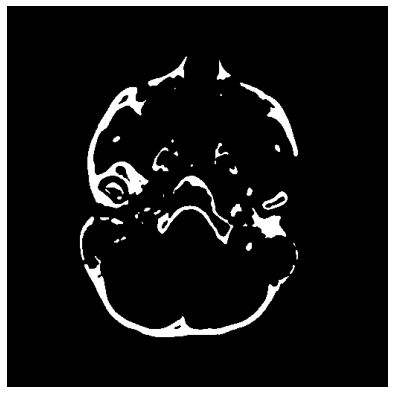

In [73]:
dicomHandler.show_dicom_image(mask)

In [74]:
org[mask] = org.max()

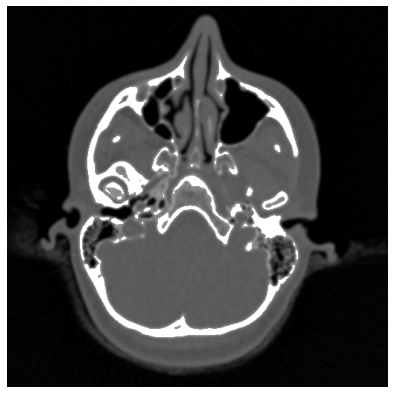

In [75]:
dicomHandler.show_dicom_image(org)

max_value = org.max()
min_value = org.min()

labels_mask = measure.label(pixel_array)

regions = measure.regionprops(labels_mask)

regions.sort(key=lambda x: x.area, reverse=True)

#for prop in regions[0]:
#    print(prop, regions[0][prop])
#print(len(regions))
all_reg = {'area':[], 'mean': [], 'std': []}

for rg in regions:
    all_sum = np.sum(org[rg.coords[:,0], rg.coords[:,1]])
    rg_std = np.std(org[rg.coords[:,0], rg.coords[:,1]])
    all_reg['area'].append(rg.area)
    all_reg['mean'].append(all_sum/rg.area)
    all_reg['std'].append(rg_std)
    #print(min_value, max_value, all_sum/rg.area)

data = pd.DataFrame(all_reg)
display(data)

if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = min_value

labels_mask[labels_mask != min_value] = max_value
new_mask = labels_mask

new_mask = new_mask.astype(np.int16)

In [76]:
from skimage import data, util, measure

def region_stdev(region, intensities):
    return np.std(intensities[region])

label_image = measure.label(pixel_array)
props = measure.regionprops_table(label_image, original_image, properties=['area', 'intensity_mean'], extra_properties=[region_stdev])

table = pd.DataFrame(props)
X_train = table.values.tolist()
print(table['area'].idxmax())

#sorted_table = table.sort_values(by='area', ascending=False)
#sorted_table.reset_index(drop=True, inplace=True)
#sorted_table.rename(columns={'area': 'Area', 'intensity_mean': 'Mean', 'region_stdev': 'Std'})

3


In [77]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_scaled = scaler.transform(X_train)

In [78]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=2).fit(X_scaled)

included_labels = kmeans.labels_

In [79]:
included_labels

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

In [80]:
def get_largest_region(pixel_array):
    max_value = pixel_array.max()
    min_value = pixel_array.min()

    labels_mask = measure.label(pixel_array)

    regions = measure.regionprops(labels_mask)
    #regions.sort(key=lambda x: x.area, reverse=True)
    
    if len(regions) > 1:
        for index in range(len(regions)):
            if not included_labels[index]:
                labels_mask[regions[index].coords[:,0], regions[index].coords[:,1]] = min_value

    labels_mask[labels_mask != min_value] = max_value
    mask = labels_mask

    return mask.astype(np.int16)

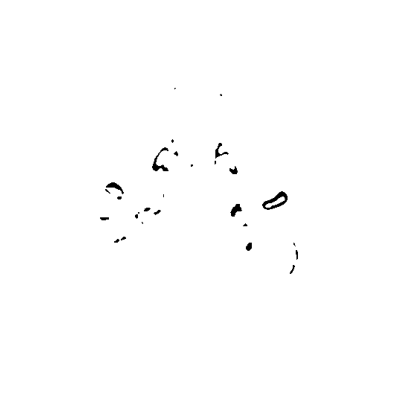

In [81]:
teste = get_largest_region(pixel_array)
dicomHandler.show_dicom_image(teste)